<a href="https://colab.research.google.com/github/gunduzarda/germanCreditData/blob/main/german_credit_data_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GERMAN CREDIT DATA ANALYSIS**




In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from numpy import random
from PIL import Image
import keras
import tensorflow as tf
from keras import layers
from keras.layers import Input, Dense, Activation, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.layers import Dropout
from keras.regularizers import l2
from keras.regularizers import l1
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import cv2
import os
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import sklearn
random.seed(42)
np.random.seed(42)

In [ ]:
data = pd.read_csv('german_credit_data.csv')
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit_amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [ ]:
#Dataframe to Preprocessed
data_for_lr = pd.read_csv('german_credit_data.csv')
data_for_lr['Saving accounts'].replace({'rich':3, 'quite rich':4, 'moderate':2, 'little':1}, inplace=True)
data_for_lr['Checking account'].replace({'rich':3, 'moderate':2, 'little':1}, inplace=True)

In [ ]:
data.isnull().sum()  #check for non existing entries

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [ ]:
data.nunique() # to distinguish if a data is categorical or continuous

Unnamed: 0          1000
Age                   53
Sex                    2
Job                    4
Housing                3
Saving accounts        4
Checking account       3
Credit amount        921
Duration              33
Purpose                8
Risk                   2
dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer
Data1 = data
Data1 = Data1.fillna(Data1.mode().iloc[0]) # to fill not available data, we replace them with the most frequent one
Data1.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit_amount,Duration,Purpose,Risk
0,0,67,male,2,own,little,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,little,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


<Axes: xlabel='Risk'>

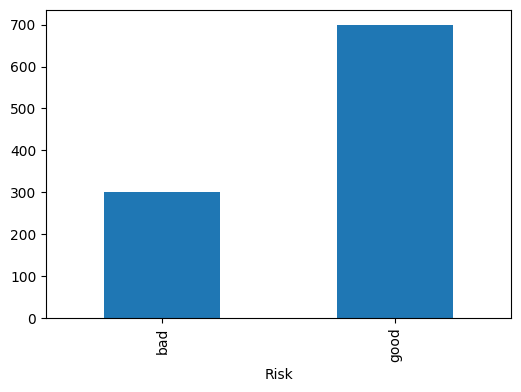

In [ ]:
%matplotlib inline
# Creating a Bar chart for Target variable.
GroupedData=data.groupby('Risk').size()
GroupedData.plot(kind='bar', figsize=(6,4))

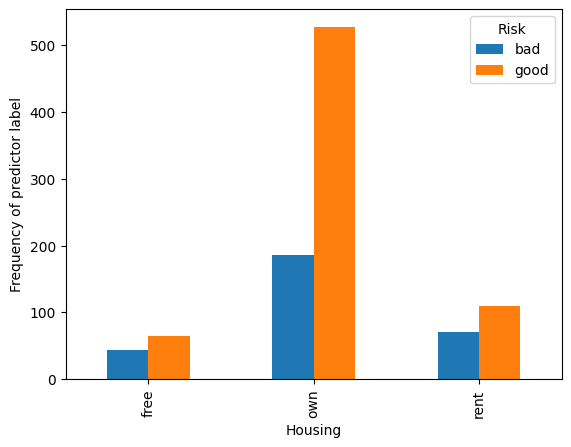

In [ ]:
a='Checking account'
pd.crosstab(Data1.Housing,Data1.Risk).plot(kind='bar')
plt.title('')
plt.xlabel('Housing')
plt.ylabel('Frequency of predictor label')
plt.savefig('image')

In [ ]:
Data1['Saving accounts'].replace({'rich':3, 'quite rich':4, 'moderate':2, 'little':1}, inplace=True)    #  Since there is a ranked ordering between values, let numbers represent the order.
Data1['Checking account'].replace({'rich':3, 'moderate':2, 'little':1}, inplace=True)

DataForML_Numeric = pd.get_dummies(Data1) # create dummies for categorical data with no order
# Adding Target Variable to the data
DataForML_Numeric = DataForML_Numeric.drop(['Risk_bad'], axis=1) # no dummies needed for target data
DataForML_Numeric = DataForML_Numeric.drop(['Risk_good'], axis=1)
#DataForML_Numeric = DataForML_Numeric.drop(['Job'], axis=1)
DataForML_Numeric['Risk']=data['Risk']
DataForML_Numeric['Risk'].replace({'good':1, 'bad':0}, inplace=True)
# Printing sample rows
DataForML_Numeric.head()

,Unnamed: 0,Age,Job,Saving accounts,Checking account,Credit_amount,Duration,Sex_female,Sex_male,Housing_free,...,Housing_rent,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,0,67,2,1,1,1169,6,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,1,22,2,1,2,5951,48,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,49,1,1,1,2096,12,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,3,45,2,1,1,7882,42,0,1,1,...,0,0,0,0,0,1,0,0,0,1
4,4,53,2,1,1,4870,24,0,1,1,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
'''
We have categorical data. For each classified data test if its correlated with Risk data.
Ex: Sex_male vs. Risk --> does customer being a male play an important role in credit risk result. If not we may delete it from data for simplicity.
'''
from scipy.stats import chi2_contingency, f_oneway

data=['Job','Saving accounts','Checking account','Sex_female','Sex_male','Housing_free','Housing_own','Housing_rent','Purpose_business',
'Purpose_car','Purpose_domestic appliances','Purpose_education','Purpose_furniture/equipment','Purpose_radio/TV', 'Purpose_repairs','Purpose_vacation/others']
PredictorsList = []

for i in data:
  # We use ChiSq test because we compare two categorical data.
  if (chi2_contingency(pd.crosstab(index=DataForML_Numeric['Risk'], columns=DataForML_Numeric[i]))[1] < 0.05): # If the ChiSq P-Value is <0.05, that means we reject H0
    PredictorsList.append(i) # data i is correlated with Risk with p-value: Result[1]

'''
We have continuous data. For each classified data test if its correlated with Risk data.
Ex: Age vs. Risk --> does customer  age play an important role in credit risk result. If not we may delete it from data for simplicity.
'''

data=['Age', 'Credit_amount',	'Duration']
for i in data:
        # We use ANOVA test because we have continous data as dependent variable, and target is categorical
  if (f_oneway(*(DataForML_Numeric.groupby('Risk')[i].apply(list)))[1] < 0.05):  # If the ANOVA P-Value is <0.05, that means we reject H0
    PredictorsList.append(i) # data i is correlated with Risk with p-value: Result[1]

print(PredictorsList )

['Saving accounts', 'Checking account', 'Sex_female', 'Sex_male', 'Housing_free', 'Housing_own', 'Housing_rent', 'Purpose_radio/TV', 'Age', 'Credit_amount', 'Duration']


In [ ]:
TargetVariable='Risk'
Predictors= ['Saving accounts', 'Checking account', 'Sex_female', 'Sex_male', 'Housing_free', 'Housing_own', 'Housing_rent', 'Purpose_radio/TV', 'Age', 'Credit_amount', 'Duration']

X=DataForML_Numeric[Predictors].values
Y=DataForML_Numeric[TargetVariable].values

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,  test_size=0.2, train_size=0.8, random_state=42, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(700, 11)
(300, 11)
(700,)
(300,)


**Standardization of data**

In [ ]:
### Standardization of data ###
from sklearn.preprocessing import MinMaxScaler
PredictorScaler=MinMaxScaler()            # standardize data. Since continous data can differ in size (i.e. Credit Amount being 4567 and age being 23) and data with larger
PredictorScalerFit=PredictorScaler.fit(X) # values can dominate the train process. To obstruct that we standardize data so no continous data creates domination.
X=PredictorScalerFit.transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # Split the data into training and testing set
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 11)
(200, 11)
(800,)
(200,)


**Code for Inputing Missing Values using HistGradientBoostingRegressor**

In [ ]:
import pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Selecting the columns for training the model
train_cols = ['Checking account', 'Job', 'Duration']
target_col = 'Saving accounts'

# Creating a new dataframe with only the relevant columns and rows without NaN values
train_data = data_for_lr[train_cols + [target_col]].dropna()

# Spliting the data into features (X) and target (y)
X_train = train_data[train_cols]
y_train = train_data[target_col]

# Creating the HistGradientBoostingRegressor model for 'Saving accounts'
gb_saving = HistGradientBoostingRegressor()
gb_saving.fit(X_train, y_train)

# Filling NaN values in 'Saving accounts' based on predictions from the model
nan_rows_saving = data_for_lr[data_for_lr['Saving accounts'].isna()]
X_pred_saving = nan_rows_saving[train_cols]
predicted_values_saving = gb_saving.predict(X_pred_saving)
nan_rows_saving['Saving accounts'] = predicted_values_saving

# Updating the original dataframe with the filled values for 'Saving accounts'
data_for_lr.update(nan_rows_saving)

# Creating the HistGradientBoostingRegressor model for 'Checking account'
gb_checking = HistGradientBoostingRegressor()
gb_checking.fit(X_train[['Duration']], X_train['Checking account'])

# Filling NaN values in 'Checking account' based on predictions from the model
nan_rows_checking = data_for_lr[data_for_lr['Checking account'].isna()]
X_pred_checking = nan_rows_checking[['Duration']]
predicted_values_checking = gb_checking.predict(X_pred_checking)
nan_rows_checking['Checking account'] = predicted_values_checking

# Updating the original dataframe with the filled values for 'Checking account'
data_for_lr.update(nan_rows_checking)

# Printing the updated dataframe
print(data_for_lr)

data_for_lr.shape

data_for_lr.isnull().sum()

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
<ipython-input-13-dad5e4445216>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_rows_saving['Saving accounts'] = predicted_values_saving


     Unnamed: 0   Age     Sex  Job Housing  Saving accounts  Checking account  \
0           0.0  67.0    male  2.0     own         1.638909          1.000000   
1           1.0  22.0  female  2.0     own         1.000000          2.000000   
2           2.0  49.0    male  1.0     own         1.000000          1.611108   
3           3.0  45.0    male  2.0    free         1.000000          1.000000   
4           4.0  53.0    male  2.0    free         1.000000          1.000000   
..          ...   ...     ...  ...     ...              ...               ...   
995       995.0  31.0  female  1.0     own         1.000000          1.611108   
996       996.0  40.0    male  3.0     own         1.000000          1.000000   
997       997.0  38.0    male  2.0     own         1.000000          1.611108   
998       998.0  23.0    male  2.0    free         1.000000          1.000000   
999       999.0  27.0    male  2.0     own         2.000000          2.000000   

     Credit amount  Duratio

<ipython-input-13-dad5e4445216>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_rows_checking['Checking account'] = predicted_values_checking


Unnamed: 0          0
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

**Correlation Analysis for 'Saving accounts' and 'Checking account':**

In [ ]:
import pandas as pd

# Selecting the columns for correlation analysis, excluding 'Checking account'
saving_corr_cols = data_for_lr.columns[data_for_lr.columns != 'Checking account']

# Calculating correlation matrix for 'Saving accounts' column with other columns
saving_corr_matrix = data_for_lr[saving_corr_cols].corr()

# Ranking the correlation results from highest to lowest
saving_corr_ranked = saving_corr_matrix['Saving accounts'].abs().sort_values(ascending=False)

# Selecting the columns for correlation analysis, excluding 'Saving accounts'
checking_corr_cols = data_for_lr.columns[data_for_lr.columns != 'Saving accounts']

# Calculating correlation matrix for 'Checking account' column with other columns
checking_corr_matrix = data_for_lr[checking_corr_cols].corr()

# Ranking the correlation results from highest to lowest
checking_corr_ranked = checking_corr_matrix['Checking account'].abs().sort_values(ascending=False)

# Printing the ranked correlation results
print("Ranked Correlation for 'Saving accounts':")
print(saving_corr_ranked)
print("\nRanked Correlation for 'Checking account':")
print(checking_corr_ranked)


Ranked Correlation for 'Saving accounts':
Saving accounts    1.000000
Credit amount      0.066639
Job                0.041297
Age                0.039041
Duration           0.028824
Unnamed: 0         0.025102
Name: Saving accounts, dtype: float64

Ranked Correlation for 'Checking account':
Checking account    1.000000
Duration            0.065434
Unnamed: 0          0.049016
Job                 0.032702
Credit amount       0.030364
Age                 0.002949
Name: Checking account, dtype: float64


<ipython-input-14-e7793d2bfa07>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  saving_corr_matrix = data_for_lr[saving_corr_cols].corr()
<ipython-input-14-e7793d2bfa07>:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  checking_corr_matrix = data_for_lr[checking_corr_cols].corr()


**P-value assesments with Risk Column**

In [ ]:
import scipy.stats as stats
new_columns = [col.replace(' ', '_') for col in data_for_lr.columns]
data_for_lr.columns = new_columns
categorical_cols = ['Sex', 'Housing', 'Purpose']

for col in categorical_cols:
    contingency_table = pd.crosstab(data_for_lr[col], data_for_lr['Risk'])
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    print(f"{col} vs Risk: p-value = {p_value}")


Sex vs Risk: p-value = 0.020739913068713305
Housing vs Risk: p-value = 0.00011167465374597684
Purpose vs Risk: p-value = 0.05792591119293633


In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

numerical_cols = ['Age', 'Job', 'Duration', 'Credit_amount', 'Saving_accounts',   'Checking_account']

for col in numerical_cols:
    formula = f"{col} ~ Risk"
    model = ols(formula, data=data_for_lr).fit()
    anova_results = anova_lm(model)
    p_value = anova_results['PR(>F)'][0]
    print(f"{col} vs Risk: p-value = {p_value}")


Age vs Risk: p-value = 0.003925339398278417
Job vs Risk: p-value = 0.30106413708867547
Duration vs Risk: p-value = 6.488049877187189e-12
Credit_amount vs Risk: p-value = 8.797572373532748e-07
Saving_accounts vs Risk: p-value = 1.485429207124361e-05
Checking_account vs Risk: p-value = 1.667202331554355e-05


**Logistic regression model, data_no_proprocess DF fillna method, that has been preprocessed by filling na values with mode.**

In [ ]:
data_no_preprocess = pd.read_csv('german_credit_data.csv')
data_no_preprocess['Saving accounts'].replace({'rich':3, 'quite rich':4, 'moderate':2, 'little':1}, inplace=True)
data_no_preprocess = data_no_preprocess.fillna(data_no_preprocess.mode().iloc[0])
data_no_preprocess.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Spliting the data into features (X) and the target variable (y)
X = data_no_preprocess.drop('Risk', axis=1)
y = data_no_preprocess['Risk']

# Preprocessing categorical variables with one-hot encoding
X_encoded = pd.get_dummies(X)

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Creating an instance of Logistic Regression
logreg = LogisticRegression()

# Training the logistic regression model
logreg.fit(X_train, y_train)

# Making predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluateing the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.705


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Define hyperparameters to search
hyperparameters = {'C': [0.01, 0.1, 1, 10, 100]}

# Create an instance of Logistic Regression
logreg = LogisticRegression()

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(logreg, hyperparameters, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print('Best Hyperparameters:', best_params)

# Train the final model with the best hyperparameters
final_model = LogisticRegression(**best_params)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Hyperparameters: {'C': 0.1}
Accuracy: 0.71
Confusion Matrix:
[[ 12  47]
 [ 11 130]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Logistic Regression with data_for_lr that has been preprocessed with regard to the highest p-values to fill the na's in the Saving accounts and Checking account columns.**

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Selecting the columns for the logistic regression model
selected_cols = ['Housing', 'Duration', 'Credit_amount', 'Saving_accounts', 'Checking_account', 'Risk']

# Creating a new dataframe with the selected columns
model_data = data_for_lr[selected_cols]

# Converting 'Housing' column to numerical values (0 for 'rent', 1 for 'own', 2 for 'free')
model_data['Housing'] = model_data['Housing'].map({'rent': 0, 'own': 1, 'free': 2})

# Converting 'Risk' column to numeric values (0 for 'bad', 1 for 'good')
model_data['Risk'] = model_data['Risk'].map({'bad': 0, 'good': 1})

# Dropping rows with any missing values
model_data = model_data.dropna()

# Spliting the data into features (X) and target (y)
X = model_data.drop('Risk', axis=1)
y = model_data['Risk']

# Adding a constant column to X for the intercept term
X = sm.add_constant(X)

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Createing the logistic regression model
logit_model = sm.Logit(y_train, X_train)

# Fitting the model
logit_result = logit_model.fit()

# Printing the model summary
print(logit_result.summary())

# Predicting the target variable for the testing set
y_pred = logit_result.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)


Optimization terminated successfully.
         Current function value: 0.574759
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  800
Model:                          Logit   Df Residuals:                      794
Method:                           MLE   Df Model:                            5
Date:                Mon, 05 Jun 2023   Pseudo R-squ.:                 0.06073
Time:                        17:04:12   Log-Likelihood:                -459.81
converged:                       True   LL-Null:                       -489.54
Covariance Type:            nonrobust   LLR p-value:                 1.573e-11
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1055      0.354      0.298      0.766      -0.588       0.799
Housing    

<ipython-input-20-b63ae1b35c77>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['Housing'] = model_data['Housing'].map({'rent': 0, 'own': 1, 'free': 2})
<ipython-input-20-b63ae1b35c77>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['Risk'] = model_data['Risk'].map({'bad': 0, 'good': 1})


Logistic Regression with fillna with mode method and without Feature Selection

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# choose parameter Penalty='l1' or C=1
# choose different values for solver 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

parameters = [ 'sag', 'newton-cg', 'liblinear', 'lbfgs', 'saga']   # <--- Fill the list



for k in parameters:
  model = LogisticRegression(C=1,penalty='l2', solver = (k))

  fitted=model.fit(X_train,y_train)
  prediction=fitted.predict(X_test)
  print("With tuned-parameter", k )
  from sklearn import metrics
  print("Confusion matrix is as \n", metrics.confusion_matrix(y_test, prediction))
  print("Report gives accuracy results as \n", metrics.classification_report(y_test, prediction))


  from sklearn.model_selection import cross_val_score
  scores=cross_val_score(fitted, X , Y, cv=5, scoring='accuracy')
  print('5-fold Cross Validation implemented:',scores)
  print("Post-Validation Average Accuracy:", (scores.mean()))
  print('\n')
  print('\n')

With tuned-parameter sag
Confusion matrix is as 
 [[ 12  47]
 [ 11 130]]
Report gives accuracy results as 
               precision    recall  f1-score   support

           0       0.52      0.20      0.29        59
           1       0.73      0.92      0.82       141

    accuracy                           0.71       200
   macro avg       0.63      0.56      0.56       200
weighted avg       0.67      0.71      0.66       200

5-fold Cross Validation implemented: [0.71  0.685 0.725 0.71  0.72 ]
Post-Validation Average Accuracy: 0.71




With tuned-parameter newton-cg
Confusion matrix is as 
 [[ 12  47]
 [ 11 130]]
Report gives accuracy results as 
               precision    recall  f1-score   support

           0       0.52      0.20      0.29        59
           1       0.73      0.92      0.82       141

    accuracy                           0.71       200
   macro avg       0.63      0.56      0.56       200
weighted avg       0.67      0.71      0.66       200

5-fold Cross

**Decision Tree Classifier with fillna with mode method and without Feature Selection**

DecisionTreeClassifier(max_depth=3)
Confusion matrix is as 
 [[ 11  48]
 [  8 133]]
Report gives accuracy results as 
               precision    recall  f1-score   support

           0       0.58      0.19      0.28        59
           1       0.73      0.94      0.83       141

    accuracy                           0.72       200
   macro avg       0.66      0.56      0.55       200
weighted avg       0.69      0.72      0.67       200

5-fold Cross Validation implemented: [0.715 0.635 0.69  0.685 0.71 ]
Post-Validation Average Accuracy: 0.687
   
   
DecisionTreeClassifier(max_depth=4)
Confusion matrix is as 
 [[  7  52]
 [  5 136]]
Report gives accuracy results as 
               precision    recall  f1-score   support

           0       0.58      0.12      0.20        59
           1       0.72      0.96      0.83       141

    accuracy                           0.71       200
   macro avg       0.65      0.54      0.51       200
weighted avg       0.68      0.71      0.64   

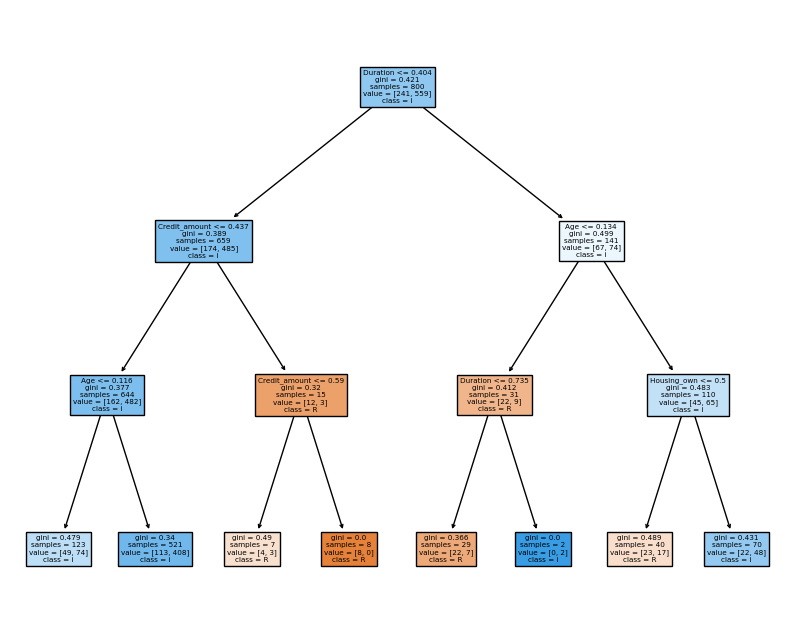

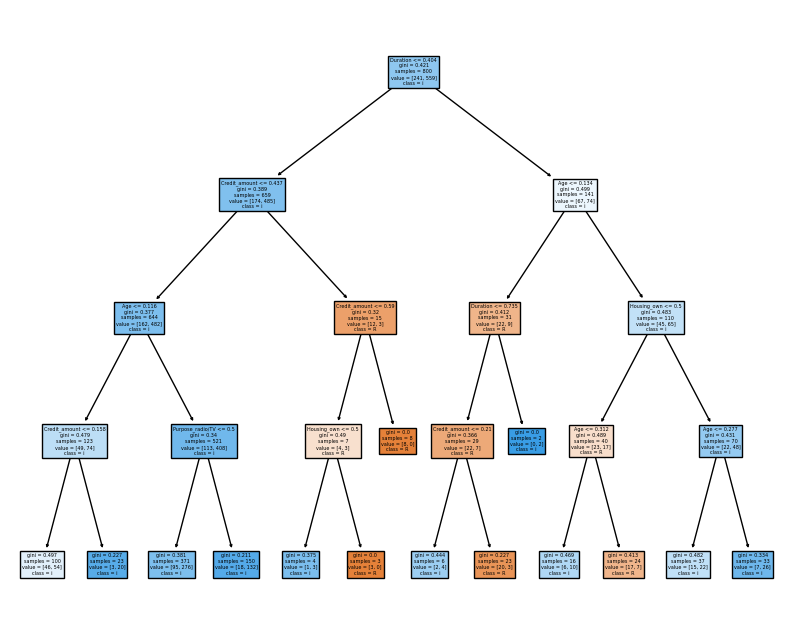

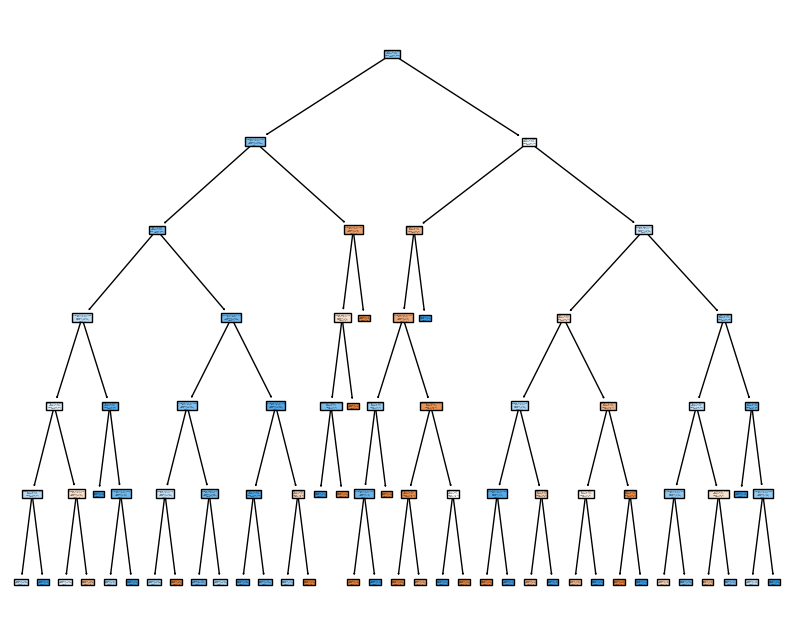

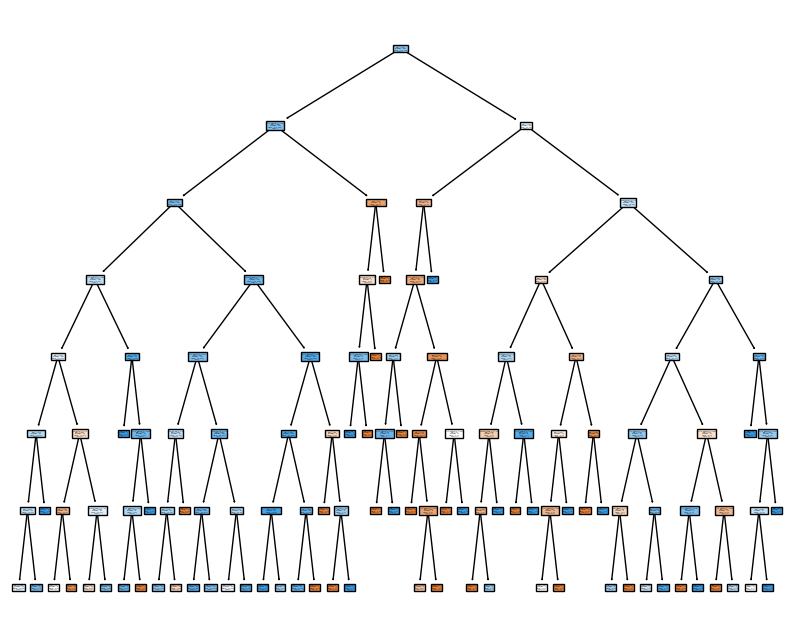

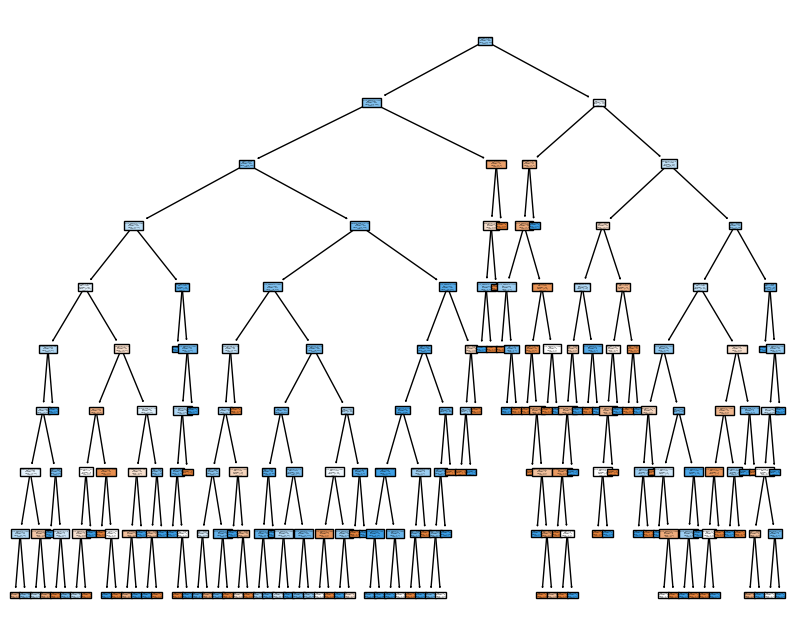

In [ ]:
# try different hyper parameters

from sklearn import tree
parameters=[3,4,6,7,9,12]
for i in range(5):
  model = tree.DecisionTreeClassifier(splitter="best",criterion='gini',max_depth=parameters[i])

  print(model)

  # Train the model
  DTree=model.fit(X_train,y_train)
  prediction=DTree.predict(X_test)

  # Accuracy on Test Data with report
  import sklearn
  print("Confusion matrix is as \n", metrics.confusion_matrix(y_test, prediction))
  print("Report gives accuracy results as \n", metrics.classification_report(y_test, prediction))


  #Cross Validate it
  scores=cross_val_score(DTree, X , Y, cv=5, scoring='accuracy')
  print('5-fold Cross Validation implemented:',scores)
  print("Post-Validation Average Accuracy:", (scores.mean()))
  print("   ")
  fig = plt.figure(figsize=(10,8))
  _ = tree.plot_tree(model, feature_names=Predictors, class_names=TargetVariable, filled=True)
  print("   ")




```
# Bu, kod olarak biçimlendirilmiştir
```

**Decision Tree with further Preprocessed Data & Feature Selection**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Selecting the features 'Age' and 'Job' for training
X = data_for_lr[['Age', 'Job']]
y = data_for_lr['Risk']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to search
hyperparameters = {'max_depth': [None, 3, 5, 7]}

# Create an instance of Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(dt_classifier, hyperparameters, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print('Best Hyperparameters:', best_params)

# Train the final model with the best hyperparameters
final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)


Best Hyperparameters: {'max_depth': 3}
Accuracy: 0.705
Confusion Matrix:
[[  1  58]
 [  1 140]]


**K-Nearest Neighbors (KNN) Classifier Selection**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = [3, 7, 9, 11, 16]   # <--- Fill the list with the values for n_neighbors
a=0
best_acc = -1
best_k = None


(train_x, val_x, train_y, val_y) = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

for k in k_values:
  # 1) initialize a k-NN classifier with n_neighbors parameter set to k
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(train_x, train_y)
  # 2) train the classifier using training set

  # 3) get the predictions of the classifier on the validation set
  obtained_score = model.score(val_x, val_y)
  # 4) compute the accuracy of the predictions on the validation set and append it to val_accs list
  print('Validation accuracy for k=', k, ' : %', ( obtained_score * 100))

 # if vlidation accuracy is better than best_acc, update best_acc and best_k
  x_conc = np.concatenate((train_x, val_x), axis=0)
  y_conc = np.concatenate((train_y, val_y), axis=0)

  the_model = model.fit(x_conc, y_conc)
  predictions = the_model.predict(X_test)
  # Measuring accuracy on Testing Data
  import sklearn
  print("Confusion matrix is as \n", metrics.confusion_matrix(y_test, prediction))
  print("Report gives accuracy results as \n", metrics.classification_report(y_test, prediction))

  scores=cross_val_score(the_model, X , Y, cv=5, scoring='accuracy')
  print('5-fold Cross Validation implemented:',scores)
  print("Post-Validation Average Accuracy:", (scores.mean()))
  print('\n')
  print('\n')

#print('Best validation accuracy (', best_acc, ') is achieved with k=', best_k)

Validation accuracy for k= 3  : % 66.875
Confusion matrix is as 
 [[ 22  37]
 [ 30 111]]
Report gives accuracy results as 
               precision    recall  f1-score   support

           0       0.42      0.37      0.40        59
           1       0.75      0.79      0.77       141

    accuracy                           0.67       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.65      0.67      0.66       200

5-fold Cross Validation implemented: [0.68  0.645 0.64  0.73  0.655]
Post-Validation Average Accuracy: 0.6700000000000002




Validation accuracy for k= 7  : % 69.375
Confusion matrix is as 
 [[ 22  37]
 [ 30 111]]
Report gives accuracy results as 
               precision    recall  f1-score   support

           0       0.42      0.37      0.40        59
           1       0.75      0.79      0.77       141

    accuracy                           0.67       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.65    

**K-Nearest Neighbors (KNN) Classifier with further Data Preprocessing & Feature Selection**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Selecting the columns for prediction (Job and Age)
selected_columns = ['Job', 'Age']

# Splitting the data into features (X) and the target variable (y)
X = data_for_lr[selected_columns]
y = data_for_lr['Risk']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to search
hyperparameters = {'n_neighbors': [3, 5, 7, 9, 11]}

# Create an instance of K-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier()

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(knn_classifier, hyperparameters, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print('Best Hyperparameters:', best_params)

# Train the final model with the best hyperparameters
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)


Best Hyperparameters: {'n_neighbors': 9}
Accuracy: 0.685
Confusion Matrix:
[[  0  59]
 [  4 137]]


**Ensemble Methods: Random Forest, Gradient Boosting, AdaBoost, Stacking, and Voting for Predictive Modeling**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

data_for_ensemble = data_for_lr.copy()

# Splitting the data into features (X) and the target variable (y)
X = data_for_ensemble.drop('Risk', axis=1)
y = data_for_ensemble['Risk']

# Converting categorical variables into numerical representation using one-hot encoding
categorical_columns = ['Sex', 'Housing', 'Purpose']
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Encoding the target variable using label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestClassifier()

# Define hyperparameters to search
rf_hyperparameters = {'n_estimators': [50, 100, 200], 'max_depth': [None, 3, 5, 7]}

# Perform grid search with 5-fold cross-validation for Random Forest
rf_grid_search = GridSearchCV(rf_model, rf_hyperparameters, cv=5)
rf_grid_search.fit(X_train, y_train)

# Get the best hyperparameters for Random Forest
best_rf_params = rf_grid_search.best_params_
print('Best Random Forest Hyperparameters:', best_rf_params)

# Train the Random Forest model with the best hyperparameters
rf_model = RandomForestClassifier(**best_rf_params)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Gradient Boosting
gb_model = GradientBoostingClassifier()

# Define hyperparameters to search
gb_hyperparameters = {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0]}

# Perform grid search with 5-fold cross-validation for Gradient Boosting
gb_grid_search = GridSearchCV(gb_model, gb_hyperparameters, cv=5)
gb_grid_search.fit(X_train, y_train)

# Get the best hyperparameters for Gradient Boosting
best_gb_params = gb_grid_search.best_params_
print('Best Gradient Boosting Hyperparameters:', best_gb_params)

# Train the Gradient Boosting model with the best hyperparameters
gb_model = GradientBoostingClassifier(**best_gb_params)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# AdaBoost
ada_model = AdaBoostClassifier()

# Define hyperparameters to search
ada_hyperparameters = {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0]}

# Perform grid search with 5-fold cross-validation for AdaBoost
ada_grid_search = GridSearchCV(ada_model, ada_hyperparameters, cv=5)
ada_grid_search.fit(X_train, y_train)

# Get the best hyperparameters for AdaBoost
best_ada_params = ada_grid_search.best_params_
print('Best AdaBoost Hyperparameters:', best_ada_params)

# Train the AdaBoost model with the best hyperparameters
ada_model = AdaBoostClassifier(**best_ada_params)
ada_model.fit(X_train, y_train)
ada_pred = ada_model.predict(X_test)

# Stacking
stacking_model = LogisticRegression()
stacking_model.fit(pd.DataFrame({'Random Forest': rf_pred, 'Gradient Boosting': gb_pred, 'AdaBoost': ada_pred}), y_test)
stacking_pred = stacking_model.predict(pd.DataFrame({'Random Forest': rf_pred, 'Gradient Boosting': gb_pred, 'AdaBoost': ada_pred}))

# Voting
voting_pred = ((rf_pred + gb_pred + ada_pred) / 3).round().astype(int)  # Round to nearest integer and convert to int

# Evaluate the models
print('Random Forest Accuracy:', accuracy_score(y_test, rf_pred))
print('Gradient Boosting Accuracy:', accuracy_score(y_test, gb_pred))
print('AdaBoost Accuracy:', accuracy_score(y_test, ada_pred))
print('Stacking Accuracy:', accuracy_score(y_test, stacking_pred))
print('Voting Accuracy:', accuracy_score(y_test, voting_pred))

# Calculate the confusion matrix for each model
print('Random Forest Confusion Matrix:')
print(confusion_matrix(y_test, rf_pred))
print('Gradient Boosting Confusion Matrix:')
print(confusion_matrix(y_test, gb_pred))
print('AdaBoost Confusion Matrix:')
print(confusion_matrix(y_test, ada_pred))
print('Stacking Confusion Matrix:')
print(confusion_matrix(y_test, stacking_pred))
print('Voting Confusion Matrix:')
print(confusion_matrix(y_test, voting_pred))


Best Random Forest Hyperparameters: {'max_depth': 7, 'n_estimators': 50}
Best Gradient Boosting Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 100}
Best AdaBoost Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 100}
Random Forest Accuracy: 0.74
Gradient Boosting Accuracy: 0.735
AdaBoost Accuracy: 0.75
Stacking Accuracy: 0.76
Voting Accuracy: 0.76
Random Forest Confusion Matrix:
[[ 12  47]
 [  5 136]]
Gradient Boosting Confusion Matrix:
[[ 23  36]
 [ 17 124]]
AdaBoost Confusion Matrix:
[[ 18  41]
 [  9 132]]
Stacking Confusion Matrix:
[[ 17  42]
 [  6 135]]
Voting Confusion Matrix:
[[ 17  42]
 [  6 135]]
